In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
from skimage.transform import resize
import cv2
from pathlib import Path
from keras.utils import np_utils
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import h5py
from sklearn.model_selection import train_test_split
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import time


seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset: 
The x-ray images dataset used in this study was published by Kermany et al. in 2018 <cite data-cite="12205583/GM3PAIRU"></cite> as part of a research project to develop a diagnostic tool based on deep learning framework to effectively screen patients for common retinal diseases <cite data-cite="12205583/SN5S4TRL"></cite>. The dataset used in this study was obtained from the Kaggle repository called “Chest X-Ray Images (Pneumonia)” <cite data-cite="12205583/5A629A8U"></cite> [link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). The dataset consists of three meta folders (training, testing, and validation folders), and each meta folder has two subfolders that contain x-ray images for either normal cases or pneumonia cases. In total, there are 5,863 x-ray chest scans that were taken from a selective cohort of pediatric patients from the Guangzhou Women and Children’s Medical Center, Guangzhou. The x-ray scans were performed on patients between the ages of one and five year old as part of their routine clinical care at the medical center.

In [2]:
data_dir = Path("/Users/trucle/Desktop/chest_xray/chest_xray")
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'
'''Loading the data and reading it using grey scale
'''

def get_data(d_dir, size):
    normal_cases_dir = d_dir / 'NORMAL'
    
    pneumonia_cases_dir = d_dir / 'PNEUMONIA'
    
    normal_cases = normal_cases_dir.glob('*.jpeg')
    
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    
    labels = ["NORMAL", "PNEUMONIA"]
    
    size = size
    
    data = []

    for l in labels:
        path = os.path.join(d_dir, l)
        class_label = labels.index(l)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (size, size)) 
            data.append([resized_arr, class_label])
    return np.array(data, dtype=object)
        

In [3]:
size = 200
train = get_data(train_dir,size)
test = get_data(test_dir, size)
val = get_data(val_dir, size)

### Data Exploratory

In [4]:
def bar_plot(data, label):    
    l = []
    counts = []
    for i in data:
        if(i[1] == 0):
            l.append("Normal")
        else:
            l.append("Pneumonia")
    counts = [l.count("Normal"),l.count("Pneumonia")]

    plt.bar(x = ["NORMAL", "PNEUMONIA"], height = counts, color = ["red","blue"])
    plt.title('Number of cases for {}'.format(label), fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(["NORMAL", "PNEUMONIA"])), ['Normal(0)', 'Pneumonia(1)'])
    plt.show()

The data looks to be very imbalance, with there being almost three times more pneumonia chest x-ray scans than the normal images. We will perform data augmentation later to address this problem.

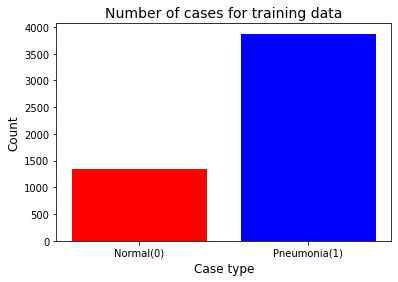

In [5]:
bar_plot(train, "training data")

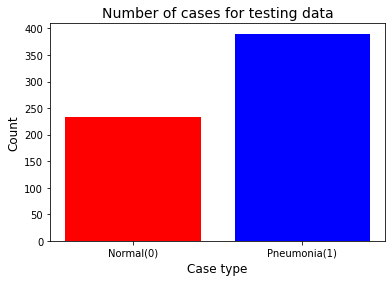

In [6]:
bar_plot(test, "testing data")

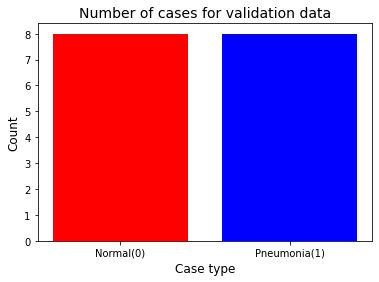

In [7]:
bar_plot(val, "validation data")

### New Training Set

There is only 16 x-ray images total in the validation set, we will combine the validation and training sets together and do a 80/20 split. This process will give us a better training dataset to train the CNN with. 

In [8]:
def comb_split(data1, data2):    
    pneum = []
    norm = []
    data = np.vstack((data1, data2))
    for i in data:
        if(i[1] == 0):
            norm.append(i)
        else:
            pneum.append(i)
            
    train, val = train_test_split(np.vstack((pneum, norm)), test_size=0.2)
    return train, val 

train, val = comb_split(train,val)

### Data Visualization

In [9]:
'''
Visualize the x-ray images in the training set
'''
def x_ray_image(data, title):
    normal_img = []
    pne_img = []
    
    for i in data:
        if(i[1] == 0):
            normal_img.append(i)
        else:
            pne_img.append(i)           
            
    f, (ax1, ax2) = plt.subplots(2,5, figsize=(30,10))
    f.suptitle("Sample set of X-Ray Images for {}".format(title), fontsize=30)
    for i in range(5):
        img1 = normal_img[i][0]
        img2 = pne_img[i][0]
        ax1[i].imshow(img1, cmap='gray')
        ax2[i].imshow(img2, cmap='gray')
        ax1[i].set_title("Normal")
        ax2[i].set_title("Pneumonia")
        ax1[i].axis('off')
        ax2[i].axis('off')
        ax1[i].set_aspect('auto')
        ax2[i].set_aspect('auto')
    plt.show()

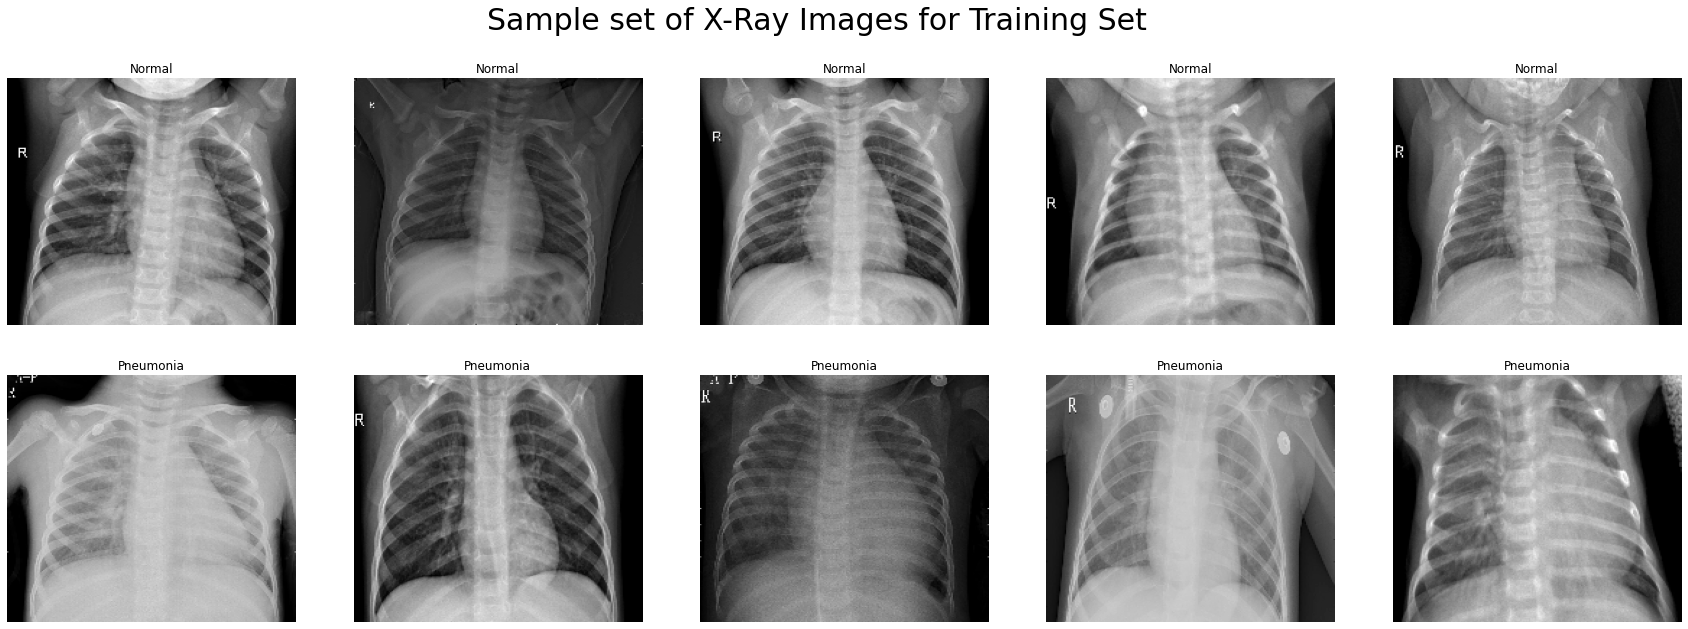

In [10]:
x_ray_image(train, "Training Set")

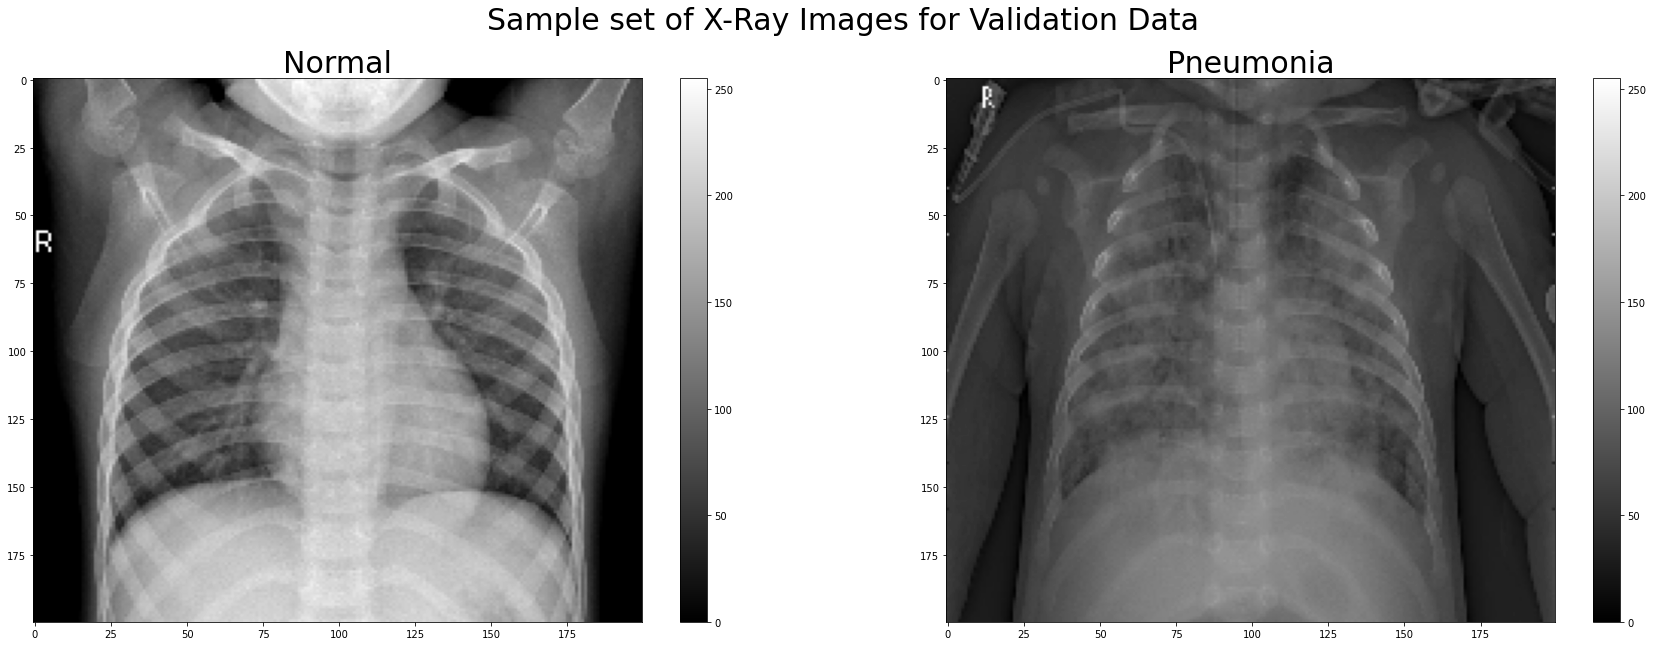

In [11]:
normal_val = []
pne_val = []

for i in val:
    if(i[1] == 0):
        normal_val.append(i)
    else:
        pne_val.append(i)  
        
norm_img = normal_val[0][0]
pne_img = pne_val[0][0]
f, (ax1, ax2) = plt.subplots(1,2, figsize=(30,10))
f.suptitle("Sample set of X-Ray Images for Validation Data", fontsize=30)
ax1.imshow(norm_img, cmap='gray')
ax2.imshow(pne_img, cmap='gray')
ax1.set_title("Normal", fontsize=30)
ax2.set_title("Pneumonia", fontsize=30)
f.colorbar(ax1.imshow(norm_img, cmap='gray'), ax=ax1)
f.colorbar(ax2.imshow(pne_img, cmap='gray'), ax=ax2)
ax1.axis('on')
ax2.axis('on')
ax1.set_aspect('auto')
ax2.set_aspect('auto')



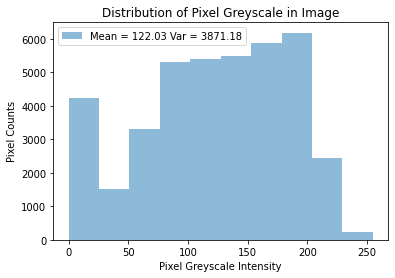

In [12]:
''' check to see if the brightness of the of the image is distributed evenly throughout the image
'''
sample = normal_val[0][0]
plt.hist(sample.ravel(), alpha=0.5)
plt.xlabel('Pixel Greyscale Intensity')
plt.ylabel('Pixel Counts')
plt.title("Distribution of Pixel Greyscale in Image")
mean = f'Mean = {np.mean(sample.ravel()):.2f}' + f' Var = {np.var(sample.ravel()):.2f}'
plt.legend([mean])
plt.show()

### Data Processing

In [13]:
'''
x = greyscale array
y = classification: Normal or Pneumonia
'''
def split_data(data):
    x = []
    y = []
    
    for img_array, label in data:
        x.append(img_array)
        y.append(label)
        
    return x, y

In [14]:
x_train, y_train = split_data(train)
x_test, y_test = split_data(test)
x_val, y_val = split_data(val)

 Grayscale normalization was performed on the images to reduce the differences in illumination effects, this is done by scaling the grayscale values of the images down by 255, reducing the values to between 0 and 1.

In [15]:
''' 
Normalizing the data to reduce the effect of illumination's differences by scaling it down by 255.
Also help the CNN algorithm to converge faster since it is now working with values between 0 and 1.
 '''
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [16]:
''' 
Prepping the data for deep learning
'''
size = 200
x_train = x_train.reshape(-1, size, size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, size, size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, size, size, 1)
y_test = np.array(y_test)

### Data Augmentation

To avoid the overfitting problem caused by the data imbalance between normal and pneumonia cases in the training set, we will artificially expand the dataset. To artificially expand the dataset, we will perform transformation to repoduce the variations, so that the x-ray images are altered but the classes of the samplees stays the same (Data Augmentation). This data augmentation process helps increase the numbers of training samples available, thus, creating a robust model.

We will use the augmentation setting provided in the following paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6458916/

In [17]:
'''
        rotation_range =  randomly rotate images by 40 degrees
        zoom_range = randomly zoom image by 0.2%
        shear_range = randomly clip the image angles in a counterclockwise direction
        width_shift_range = randomly shift images horizontally by 0.2% (fraction of total width)
        height_shift_range= randomly shift images vertically by 0.2% (fraction of total height)
        horizontal_flip = randomly flip images
'''
datagen = ImageDataGenerator(
        rotation_range = 40, 
        zoom_range = 0.2, 
        shear_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip = True, 
)


datagen.fit(x_train)

# Model Building

These are the links that explain the concepts behind Convolutional Neural Network:

https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2#a86a

https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050

https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution

In [18]:
def conv_block():
    '''
    tf.keras.Sequential: groups a linear stack of layers into model
    Convolution block: max-pooling and batch-normalization.
    Convolution layer has been moved to the model function
    '''
    block = tf.keras.Sequential([
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides = 2,  padding = 'same')
     ])
    return block


def dense_block(units, rate):
    '''
    Dropout: dropouts to reduce over-fitting
    '''
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units = units, activation = 'relu'),
        tf.keras.layers.Dropout(rate = rate)
    ])
    return block


In [41]:
def construct_model():
    '''
    Constructing the model for the Convolution Neural Network using TensorFlow sequential function
    5 convolution blocks
    2 dense blocks
    '''
    model = tf.keras.Sequential([
         tf.keras.layers.Input(shape=(200, 200, 1)),
         tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         conv_block(),
         
         tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         conv_block(),
         

         tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         #tf.keras.layers.Dropout(rate = 0.1),
         conv_block(),
        
         tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         conv_block(),
         
         tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         #tf.keras.layers.Dropout(rate = 0.2),
         conv_block(),
        
         tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         conv_block(),
        
         tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', strides = 1),
         #tf.keras.layers.Dropout(rate = 0.2),
         conv_block(),
        
        
         
         tf.keras.layers.Flatten(),
         dense_block(512, 0.5),
         #dense_block(256, 0.2),
         #dense_block(128, 0.2),
        
         tf.keras.layers.Dense(1, activation='sigmoid')
     ])
    return model
         

model = construct_model()
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 sequential_49 (Sequential)  (None, 100, 100, 32)      128       
                                                                 
 conv2d_38 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 sequential_50 (Sequential)  (None, 50, 50, 32)        128       
                                                                 
 conv2d_39 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 sequential_51 (Sequential)  (None, 25, 25, 64)        256       
                                                                 
 conv2d_40 (Conv2D)          (None, 25, 25, 64)      

In [42]:
''' Reducing the learning rate when model does not look like it is improving
'''
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [43]:
'''
Batch size 32 is choosen since it is the most common batch size
Epoch = number of times the entire dataset passed through the neural network back and forth once
EPoch 12 was choosen since anything higher seems to make the accuracy of the model goes down
Run time is listed at the end 
'''
start_time = time.time()
history = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs = 20,
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [lr_reduction]
)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
131/131 [==============================] - 189s 1s/step - loss: 0.6145 - accuracy: 0.8119 - val_loss: 13.9041 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 165s 1s/step - loss: 0.3212 - accuracy: 0.8664 - val_loss: 30.4862 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8894
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 169s 1s/step - loss: 0.2780 - accuracy: 0.8894 - val_loss: 23.0880 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 168s 1s/step - loss: 0.1897 - accuracy: 0.9286 - val_loss: 11.3273 - val_accuracy: 0.7593 - lr: 3.0000e-04
Epoch 5/20
131/131 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9400
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
131/131 [==========================

In [46]:
''' 
Evaluating the model
'''
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 346ms/step - loss: 0.3409 - accuracy: 0.9006
Loss of the model is -  0.34087854623794556
20/20 [==============================] - 7s 335ms/step - loss: 0.3409 - accuracy: 0.9006
Accuracy of the model is -  90.06410241127014 %


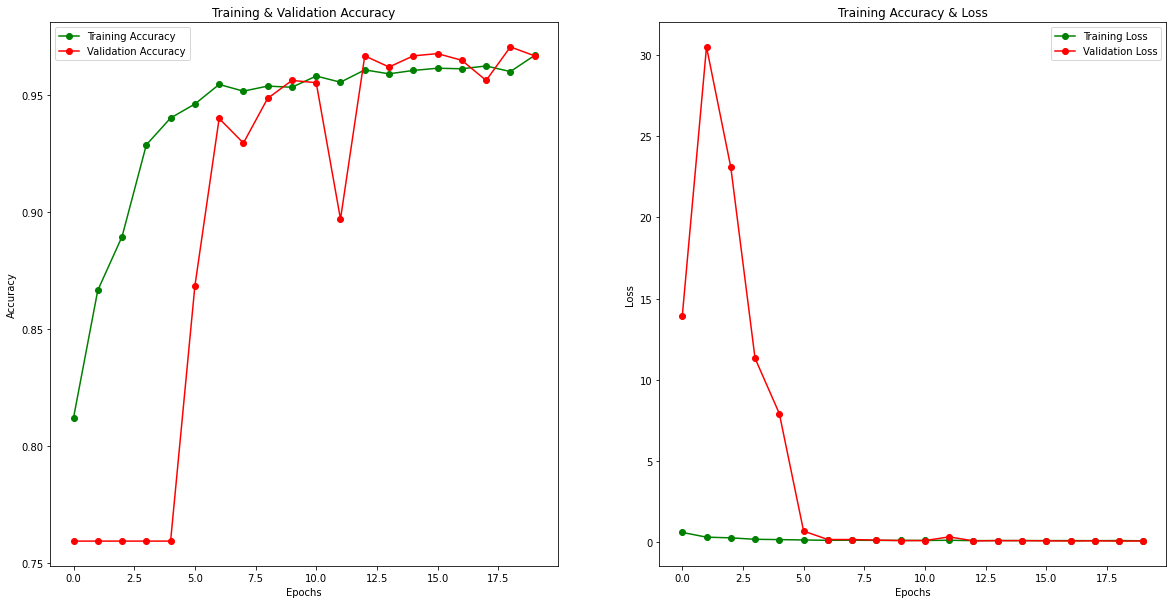

In [47]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [48]:
predictions = model.predict(x_test)
y_pred = np.round(predictions.flatten())


In [49]:
print(classification_report(y_test, y_pred, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.84      0.86       234
Pneumonia (Class 1)       0.91      0.94      0.92       390

           accuracy                           0.90       624
          macro avg       0.90      0.89      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [50]:
cm = confusion_matrix(y_test,y_pred)
cm
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

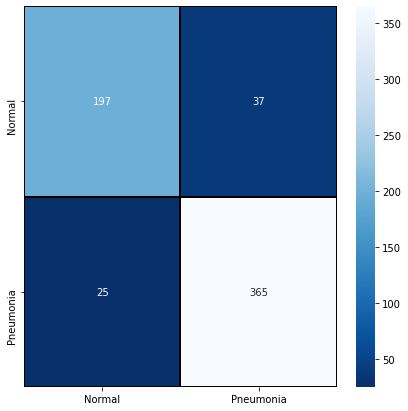

In [51]:
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Blues_r", linecolor = 'black' , linewidth = 2 ,
           annot = True, fmt='',xticklabels = ["Normal", "Pneumonia"],
            yticklabels = ["Normal", "Pneumonia"]
           )

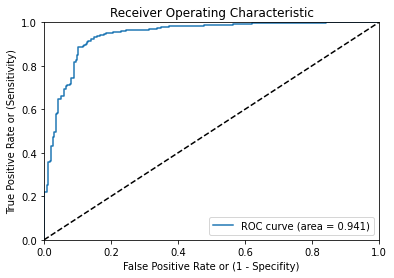

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

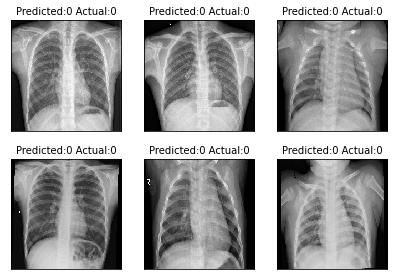

In [53]:
correct = np.nonzero(y_pred == y_test)[0]
incorrect = np.nonzero(y_pred != y_test)[0]


i = 0
for c in correct[:6]:
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(200,200), cmap="gray", interpolation='none')
    plt.title("Predicted:{} Actual:{}".format(int(y_pred[c]), y_test[c]), fontsize=10)
    plt.tight_layout()
    i += 1
    
